In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/MBTI_Music

/content/drive/MyDrive/MBTI_Music


## Library

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split,Subset
import os
import librosa
import numpy as np
import torch.nn as nn
import time
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as transforms
from torchaudio.transforms import MFCC
import random
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.optim.lr_scheduler import ReduceLROnPlateau


seed = 2024
random.seed(seed)
np.random.seed(seed)


## Dataset, loader

In [ ]:
class MyDatasetPreprocessor:
    def __init__(self, root_dir, max_frame=6000, sample_rate=8000):
        self.root_dir = root_dir
        self.max_frame = max_frame
        self.sample_rate = sample_rate

    def preprocess_and_save(self):
        mfccs = []
        labels = []
        cnt =0

        # MBTI 타입에 따른 레이블 생성
        mbti_types = ["INTP", "INTJ", "INFP", "INFJ", "ISTP", "ISTJ", "ISFP", "ISFJ",
                      "ENTP", "ENTJ", "ENFP", "ENFJ", "ESTP", "ESTJ", "ESFP", "ESFJ"]

        mbti_labels = []
        label_dict = {mbti: i for i, mbti in enumerate(mbti_types)}

        for dir_name in os.listdir(self.root_dir):
            dir_path = os.path.join(self.root_dir, dir_name)
            if os.path.isdir(dir_path):
                for filename in os.listdir(dir_path):
                    if filename.endswith('.flac'):
                        file_path = os.path.join(dir_path, filename)

                        mbti_labels = []
                        mbti_labels.append(np.array([1.0 if mbti_type == dir_name else 0.4 for mbti_type in mbti_types], dtype=np.float32).reshape(-1, 1))

                        waveform, sr = torchaudio.load(file_path)
                        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)(waveform)

                        # 스테레오 오디오를 모노로 변환
                        if waveform.size(0) > 1:
                            waveform = torch.mean(waveform, dim=0, keepdim=True)

                        # MFCC 변환 설정 및 계산
                        mfcc_transform = MFCC(sample_rate=self.sample_rate, n_mfcc=20)
                        mfcc = mfcc_transform(waveform)

                        # 최대 프레임 길이로 조정
                        if mfcc.size(-1) > self.max_frame:
                            mfcc = mfcc[:, :, :self.max_frame]
                        elif mfcc.size(-1) < self.max_frame:
                            mfcc = torch.nn.functional.pad(mfcc, (0, self.max_frame - mfcc.size(-1)))

                        mfccs.append(mfcc.squeeze())  # 차원 축소
                        labels.append(mbti_labels)  # 레이블 할당
                        cnt += 1
                        print(cnt)

        # 리스트를 텐서로 변환
        mfccs_tensor = torch.stack(mfccs)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        # 파일로 저장
        torch.save(mfccs_tensor, 'mfccs.pt')
        torch.save(labels_tensor, 'labels.pt')

# 사용 예:
root_dir = './songs'  # 오디오 파일이 위치한 디렉토리 경로를 설정하세요.
preprocessor = MyDatasetPreprocessor(root_dir)
preprocessor.preprocess_and_save()

1
2


KeyboardInterrupt: 

In [ ]:
class PreprocessedDataset(Dataset):
    def __init__(self, mfccs_file, labels_file):
        self.mfccs = torch.load(mfccs_file)
        self.labels = torch.load(labels_file)

    def __len__(self):
        return len(self.mfccs)

    def __getitem__(self, idx):
        return self.mfccs[idx], self.labels[idx]

def balanced_split(dataset, num_classes=16, num_samples_per_class=10):
    # 각 클래스별 인덱스 초기화
    indices_per_class = {i: [] for i in range(num_classes)}

    # 데이터셋을 순회하며 각 클래스별 인덱스 수집
    for idx, (data, label) in enumerate(dataset):
        class_idx = label.argmax().item()  # 최대값을 가진 인덱스를 클래스 인덱스로 사용
        indices_per_class[class_idx].append(idx)

    # 각 클래스에서 동일한 수의 샘플 선택
    test_indices = []
    valid_indices = []
    for indices in indices_per_class.values():
        # 인덱스를 무작위로 섞음
        np.random.shuffle(indices)
        test_indices.extend(indices[:num_samples_per_class])
        valid_indices.extend(indices[num_samples_per_class:2*num_samples_per_class])

    # 남은 인덱스는 훈련 데이터셋으로 사용
    remaining_indices = list(set(range(len(dataset))) - set(test_indices) - set(valid_indices))

    return remaining_indices, test_indices, valid_indices

mfccs_file = 'mfccs.pt'
labels_file = 'labels.pt'

# 데이터셋 인스턴스 생성
dataset = PreprocessedDataset(mfccs_file, labels_file)

# 균형 잡힌 데이터셋 분할
train_indices, test_indices, valid_indices = balanced_split(dataset)

# Subset을 사용하여 실제 데이터셋 생성
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
valid_dataset = Subset(dataset, valid_indices)

# DataLoader 인스턴스 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

print(f'Total dataset size: {len(dataset)}')
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Valid dataset size: {len(valid_dataset)}')

Total dataset size: 1600
Train dataset size: 1280
Test dataset size: 160
Valid dataset size: 160


In [ ]:
a,b = train_dataset[289]

print(a)

print(len(valid_loader))



tensor([[-4.8810e+02, -4.8810e+02, -4.8810e+02,  ..., -7.6499e+01,
          2.3328e+01,  1.0318e+01],
        [ 2.0316e-05,  2.0316e-05,  2.0316e-05,  ...,  9.1295e+01,
          1.2522e+02,  1.2659e+02],
        [-1.6093e-05, -1.6093e-05, -1.6093e-05,  ...,  3.7107e+00,
          4.5896e+00,  4.6499e-01],
        ...,
        [ 7.9156e-05,  7.9156e-05,  7.9156e-05,  ..., -8.8106e+00,
         -2.0668e+00, -8.8080e+00],
        [ 3.6753e-05,  3.6753e-05,  3.6753e-05,  ..., -2.0987e+01,
         -4.0327e+00, -1.3651e+01],
        [ 5.6933e-06,  5.6933e-06,  5.6933e-06,  ...,  4.8262e+00,
         -4.5475e+00, -9.5937e+00]])
10


## Model

In [ ]:
class CustomMBTIDecoder(nn.Module):
    def __init__(self, model_dim, num_heads, num_layers, input_seq_len):
        super(CustomMBTIDecoder, self).__init__()
        self.transformer_decoder = TransformerDecoder(
            TransformerDecoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True),
            num_layers=num_layers
        )
        # Flatten 레이어는 기본적으로 필요하지 않습니다; 여기서는 seq_len과 model_dim을 곱합니다.
        self.fc_layers = nn.Sequential(
            nn.Linear(input_seq_len * model_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()  # MBTI 선호도를 0과 1 사이의 값으로 출력
        )

    def forward(self, tgt, memory):
        # Decoder는 memory와 함께 tgt를 처리합니다.
        decoder_output = self.transformer_decoder(tgt, memory)
        # 출력을 적절한 차원으로 변환합니다.
        flattened_output = decoder_output.view(decoder_output.size(0), -1)
        # 완전 연결 레이어를 통과합니다.
        return self.fc_layers(flattened_output)

In [ ]:
class MusicPreferenceTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, num_mbti_types=16):
        super().__init__()
        self.input_dim = input_dim  # 입력 차원
        self.model_dim = model_dim  # 모델 차원
        self.num_heads = num_heads  # 어텐션 헤드의 개수
        self.num_layers = num_layers  # 트랜스포머 레이어의 개수
        self.num_mbti_types = num_mbti_types  # MBTI 유형의 개수

        # 인코더: 특성 임베딩과 트랜스포머 인코더 레이어
        self.feature_embedding = nn.Linear(input_dim, model_dim)  # 특성 임베딩
        encoder_layer = TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)  # 인코더 레이어
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)  # 트랜스포머 인코더

        self.mbti_decoders = nn.ModuleList([
    CustomMBTIDecoder(model_dim=model_dim, num_heads=num_heads, num_layers=num_layers, input_seq_len=16)
    for _ in range(num_mbti_types)
])

        # 임시적인 디코더 입력 생성을 위한 임베딩 레이어
        self.decoder_input_embedding = nn.Parameter(torch.randn(16, model_dim))

    def forward(self, x):
        # x의 형태: [batch_size, sequence_length, input_dim] 로
        x = x.permute(0,2,1)
        x = self.feature_embedding(x)  # [B, 6000, model_dim] : frame

        # 특성 인코딩
        memory = self.transformer_encoder(x)  # [sequence_length, batch_size, model_dim]
        memory = memory.permute(1, 0, 2)  # [batch_size, sequence_length, model_dim]
        #print(memory.shape)

        # 디코더 입력
        tgt = self.decoder_input_embedding.expand(memory.size(0), -1, self.model_dim)  # [batch_size, 1, model_dim]

        # 각 MBTI 타입에 대한 선호도 디코드
        mbti_preferences = [decoder(tgt, memory) for decoder in self.mbti_decoders]
        mbti_preferences = torch.stack(mbti_preferences, dim=-1).squeeze(2)  # [batch_size, num_mbti_types]

        return mbti_preferences

In [ ]:
class MusicPreferenceTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, num_mbti_types=16, seq_len=6000):
        super(MusicPreferenceTransformer, self).__init__()
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.num_mbti_types = num_mbti_types
        self.seq_len = seq_len

        self.feature_embedding = nn.Linear(input_dim, model_dim)
        encoder_layer = TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.mbti_decoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(model_dim, model_dim),
                nn.ReLU(),
                nn.Linear(model_dim, 1),
                nn.ReLU()
            ) for _ in range(num_mbti_types)
        ])

        #  각 시퀀스 점수 통합
        self.sequence_integration = nn.ModuleList([
            nn.Sequential(
                nn.Linear(self.seq_len, model_dim),
                nn.ReLU(),
                nn.Linear(model_dim, 1),
                nn.Sigmoid()
            ) for _ in range(num_mbti_types)
        ])

    def forward(self, x):
        # x: [batch_size, input_dim, seq_len]
        x = x.permute(0, 2, 1)
        x = self.feature_embedding(x)  # [batch_size, seq_len, model_dim]
        x = self.transformer_encoder(x)  # [batch_size, seq_len, model_dim]

        # 각 MBTI 타입에 대한 선호도 계산
        mbti_preferences = [decoder(x) for decoder in self.mbti_decoders]  # List of [batch_size, seq_len, 1]
        mbti_preferences = torch.cat(mbti_preferences, dim=-1)  # [batch_size, seq_len, num_mbti_types]

        # 시퀀스에 대한 점수를 하나의 점수로 통합
        mbti_preferences = mbti_preferences.permute(0, 2, 1)  # [batch_size, num_mbti_types, seq_len]

        mbti_scores = []
        for i, integrator in enumerate(self.sequence_integration):
          integrated_score = integrator(mbti_preferences[:, i, :])  # Process each MBTI type separately
          mbti_scores.append(integrated_score)

        mbti_scores = torch.cat(mbti_scores, dim=1)  # [batch_size, num_mbti_types]

        return mbti_scores


## Training and Inference

In [ ]:
class WeightedBCELoss(nn.Module):
    def __init__(self, weight=16.0):  # 1.0 레이블에 적용될 가중치
        super().__init__()
        self.weight = weight
        self.bce_loss = nn.BCELoss(reduction='none')  # 개별 손실값을 계산

    def forward(self, predictions, targets):
        # 기본 Binary Cross Entropy 손실 계산
        losses = self.bce_loss(predictions, targets)
        # 1.0 레이블에 대한 가중치 적용
        weights = torch.where(targets == 1.0, self.weight, 1.0)
        weighted_losses = losses * weights  # 가중치 적용된 손실
        # 배치 내 모든 손실의 평균을 반환
        return weighted_losses.mean()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MusicPreferenceTransformer(input_dim=20, model_dim=256, num_heads=4, num_layers=4, num_mbti_types=16).to(device)

#model.load_state_dict(torch.load('my_model_.pth'))

criterion = WeightedBCELoss(weight=18.0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


num_epochs = 20
min_loss = float(1.94919658)  # 이전 에포크의 최소 손실을 저장하기 위한 변수


train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()
    train_loss = 0.0
    for music_features, labels in train_loader:
        music_features, labels = music_features.to(device), labels.squeeze().to(device)
        optimizer.zero_grad()
        outputs = model(music_features)
        #_, true_labels = torch.max(labels, 1)  # labels 인덱싱 수정
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for music_features, labels in valid_loader:
            music_features, labels = music_features.to(device), labels.squeeze().to(device)
            outputs = model(music_features)
            _, true_labels = torch.max(labels, 1)  # labels 인덱싱 수정
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)


    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start

    scheduler.step(valid_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.8f}, Valid Loss: {valid_loss:.8f}, Time: {epoch_time:.2f} sec')

    if valid_loss < min_loss:
        print("Valid loss decreased ({:.8f} --> {:.8f}). Saving model...".format(min_loss, valid_loss))
        torch.save(model.state_dict(), 'my_model_new2.pth')
        min_loss = valid_loss

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/20], Train Loss: 1.40929562, Valid Loss: 1.40574484, Time: 124.84 sec
Valid loss decreased (1.94919658 --> 1.40574484). Saving model...
Epoch [2/20], Train Loss: 1.41174621, Valid Loss: 1.40564353, Time: 124.97 sec
Valid loss decreased (1.40574484 --> 1.40564353). Saving model...
Epoch [3/20], Train Loss: 1.39096116, Valid Loss: 1.39503070, Time: 125.03 sec
Valid loss decreased (1.40564353 --> 1.39503070). Saving model...
Epoch [4/20], Train Loss: 1.37558165, Valid Loss: 1.36957699, Time: 125.00 sec
Valid loss decreased (1.39503070 --> 1.36957699). Saving model...
Epoch [5/20], Train Loss: 1.35681340, Valid Loss: 1.36305546, Time: 125.03 sec
Valid loss decreased (1.36957699 --> 1.36305546). Saving model...
Epoch [6/20], Train Loss: 1.34011791, Valid Loss: 1.33641210, Time: 125.01 sec
Valid loss decreased (1.36305546 --> 1.33641210). Saving model...
Epoch [7/20], Train Loss: 1.31635317, Valid Loss: 1.32166858, Time: 125.03 sec
Valid loss decreased (1.33641210 --> 1.32166858). S

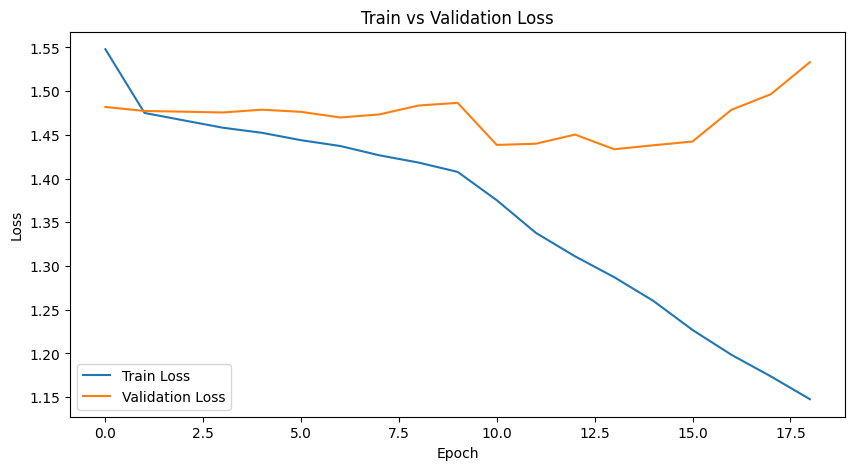

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

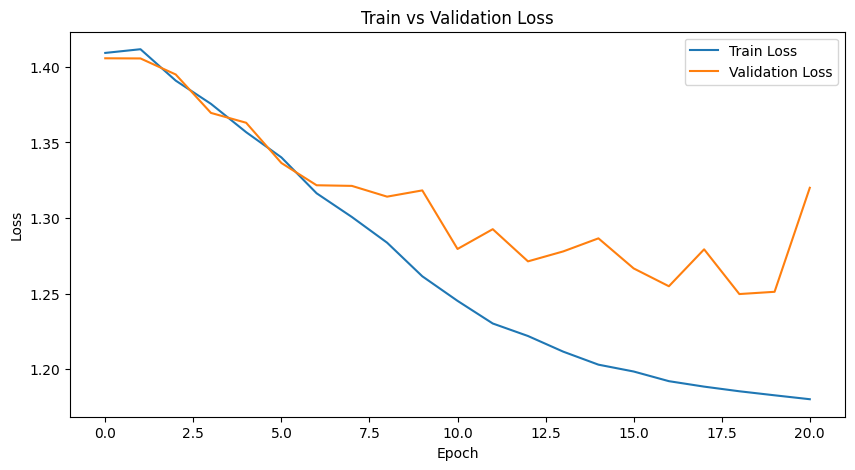

In [ ]:
import matplotlib.pyplot as plt

train_losses.pop(20)
valid_losses.pop(20)

train_losses.append(1.18)
valid_losses.append(1.32)

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = MusicPreferenceTransformer(input_dim=20, model_dim=256, num_heads=4, num_layers=4, num_mbti_types=16).to(device)
model.load_state_dict(torch.load('my_model_two.pth'))
model.eval()  # 모델을 평가 모드로 설정

total = 0
correct = 0

with torch.no_grad():
    for music_features, labels in test_loader:
        music_features = music_features.to(device)
        labels = labels.squeeze().to(device)

        outputs = model(music_features).squeeze()
        #print(outputs)
        _, predicted_labels = torch.max(outputs, 1)
        _, true_labels = torch.max(labels, 1)

        total += labels.size(0)
        correct += (predicted_labels == true_labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 13.12%
